In [137]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn import tree
from sklearn.tree import export_text
import graphviz as gr


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from typing import *

from sklearn.metrics import accuracy_score, f1_score

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

plt.style.use('ggplot')


 # План:
 ## 1) Подгрузить датасет, посмотреть матрицу корреляции, распределения
 ## 2) Preproccessing
 ## 2.5) разбиение train/valid/test
 ## 3) 3. Обучить несколько моделей (RandomForest, GradientBoosting, GaussianNB)
 ## 4) посмотреть метрики (Precission, Recall, f1_score)
 ## 5) Применить autoML к моделям
 ## 6) посмотреть результаты затюненых моделей
 ## 7) Добавление синтетических данных
 ## 8) autoML после добавления синтетических данных
 ## 9) Обзор результатов

# 1. Подгрузить датасет, посмотреть матрицу корреляции, распределения

In [138]:
TRAIN_PATH = '/content/drive/MyDrive/wine_data/'

In [139]:
df = pd.read_csv(TRAIN_PATH + 'WineQT.csv')

In [140]:
display(df.head())
classes = df.columns
print('Names of classes', classes)
for col in df.columns:
    print(col, 'число уникальных значений в столбце: ', df[col].nunique())
    print(''.ljust(len(col)), 'тип столбца ', df[col].dtype, '\n')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


Names of classes Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'Id'],
      dtype='object')
fixed acidity число уникальных значений в столбце:  91
              тип столбца  float64 

volatile acidity число уникальных значений в столбце:  135
                 тип столбца  float64 

citric acid число уникальных значений в столбце:  77
            тип столбца  float64 

residual sugar число уникальных значений в столбце:  80
               тип столбца  float64 

chlorides число уникальных значений в столбце:  131
          тип столбца  float64 

free sulfur dioxide число уникальных значений в столбце:  53
                    тип столбца  float64 

total sulfur dioxide число уникальных значений в столбце:  138
                     тип столбца  float64 

density число уникальных значений в столбце:  388
        тип столбца  float64 

p

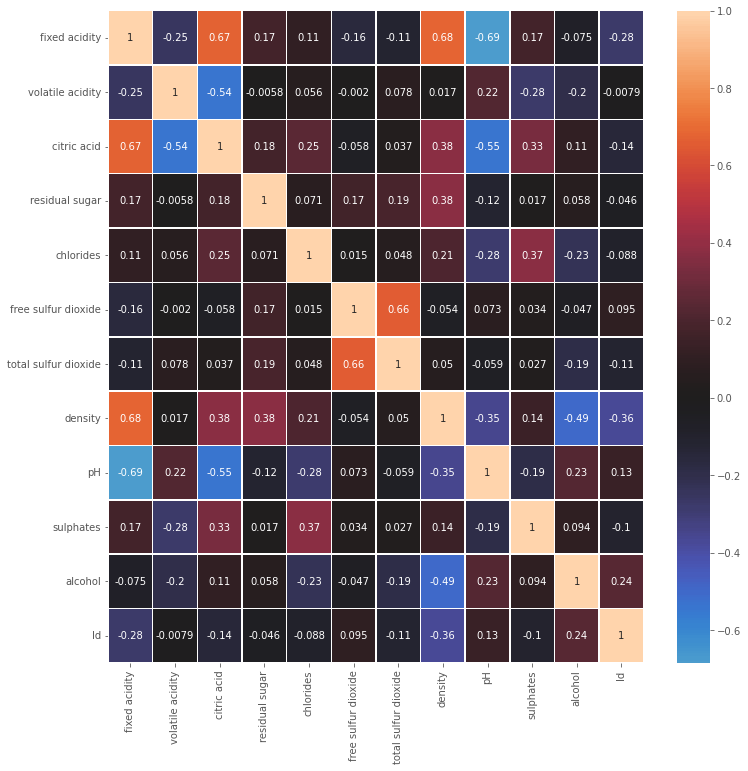

In [141]:
plt.figure(figsize=(len(classes) - 1, len(classes) - 1))
sns.heatmap(data=df.drop(columns='quality').corr(), annot=True, linewidths=.5, center=0)
plt.show()

Нет признаков с сильной положительной или отрицательной связью

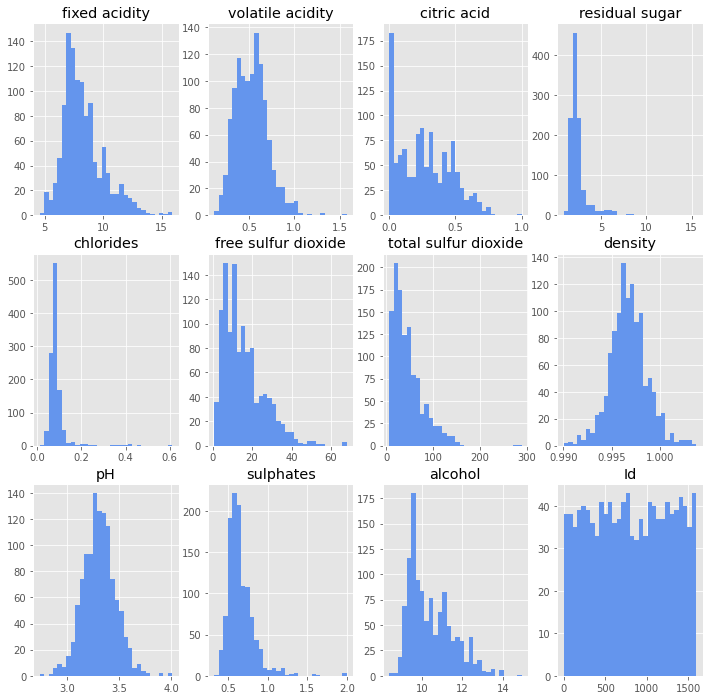

In [142]:
plt.figure(figsize=(len(classes) - 1,len(classes) - 1))
for i, col in enumerate(df.drop(columns='quality').columns):
    plt.subplot(3, 4, i+1)
    if df[col].dtype == 'object':
        df[col].value_counts().plot(kind='bar', color='cornflowerblue')
        plt.title(col)
    elif df[col].dtype != 'object' and df[col].nunique() <= 16:
        df[col].value_counts().sort_index().plot(kind='bar', color='cornflowerblue')
        plt.title(col)
    else:
        df[col].hist(bins=30, color='cornflowerblue')
        plt.title(col)

# 2. Preprocessing

ID - неинформативный признак <br>
residual sugar - есть выбросы <br>
chlorides, sulphates, total sulfur dioxide - возможно выбросы<br>
Большинство признаков имеют нормальное распределение<br>

In [143]:
column_names = df.columns
column_names = ['quality']
for col in column_names:
    print(df[col].value_counts(normalize=False))

5    483
6    462
7    143
4     33
8     16
3      6
Name: quality, dtype: int64


In [144]:
clean_df = df.copy()
print(clean_df.shape)
clean_df = clean_df.drop(columns={"Id"})
print(clean_df.shape)
clean_df = clean_df[clean_df['residual sugar'] < 10]
print(clean_df.shape)
clean_df = clean_df[clean_df['total sulfur dioxide'] < 200]
print(clean_df.shape)


(1143, 13)
(1143, 12)
(1137, 12)
(1135, 12)


In [145]:
column_names = ['quality']
for col in column_names:
    print(df[col].value_counts(normalize=False))
    print(clean_df[col].value_counts(normalize=False))

5    483
6    462
7    143
4     33
8     16
3      6
Name: quality, dtype: int64
5    480
6    459
7    141
4     33
8     16
3      6
Name: quality, dtype: int64


In [146]:
print(clean_df.shape)
clean_df = clean_df[clean_df['sulphates'] < 1.5]
print(clean_df.shape)
clean_df = clean_df[clean_df['chlorides'] < 0.3]
print(clean_df.shape)

(1135, 12)
(1129, 12)
(1116, 12)


In [147]:
column_names = ['quality']
for col in column_names:
    print(df[col].value_counts(normalize=False))
    print(clean_df[col].value_counts(normalize=False))

5    483
6    462
7    143
4     33
8     16
3      6
Name: quality, dtype: int64
5    470
6    452
7    140
4     32
8     16
3      6
Name: quality, dtype: int64


Таким образом мы приблизили данные к нормальному распределению, не потеряв при этом малочисленных классов

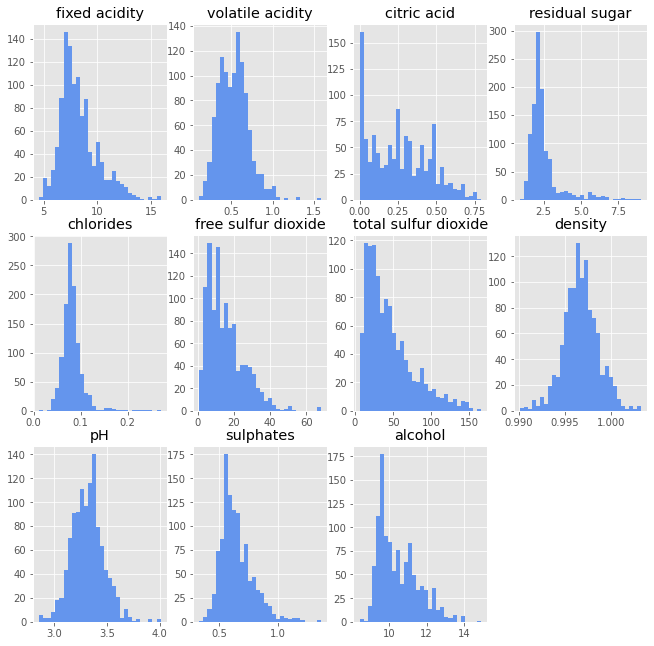

In [148]:
column_names = clean_df.columns
plt.figure(figsize=(len(column_names) - 1,len(column_names) - 1))
for i, col in enumerate(clean_df.drop(columns='quality').columns):
    plt.subplot(3, 4, i+1)
    if clean_df[col].dtype == 'object':
        clean_df[col].value_counts().plot(kind='bar', color='cornflowerblue')
        plt.title(col)
    elif clean_df[col].dtype != 'object' and clean_df[col].nunique() <= 16:
        clean_df[col].value_counts().sort_index().plot(kind='bar', color='cornflowerblue')
        plt.title(col)
    else:
        clean_df[col].hist(bins=30, color='cornflowerblue')
        plt.title(col)

# 2.5 train/valid/test

In [149]:
X = clean_df.drop(columns='quality')
y = clean_df['quality']


In [150]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42, shuffle=True)

In [151]:
print(X_train.shape)

print(X_test.shape)

(892, 11)
(224, 11)


In [152]:
print(y_train.value_counts(normalize=False))
print(y_test.value_counts(normalize=False))
print(y_test.value_counts(normalize=False))

5    376
6    361
7    112
4     25
8     13
3      5
Name: quality, dtype: int64
5    94
6    91
7    28
4     7
8     3
3     1
Name: quality, dtype: int64
5    94
6    91
7    28
4     7
8     3
3     1
Name: quality, dtype: int64


# 3. Обучить несколько моделей (RandomForest, GradientBoosting, GaussianNB)

In [153]:
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, datasets
from sklearn import metrics
from sklearn.utils import multiclass
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
n_tree = 30
depth = 6


In [154]:
models = [GradientBoostingClassifier(n_estimators=n_tree, max_depth=depth, random_state=42),
          RandomForestClassifier(n_estimators=n_tree, max_depth=depth, random_state=42),
          GaussianNB(),
          ]

#fit_models = [clf.fit(X_train, y_train) for clf in models]

names = ['Gradient Boosting', 
         'Random Forest',
         'GaussianNB',
         ]

In [155]:
for model, name in zip(models, names):
  model.fit(X_train, y_train)

# 4) посмотреть метрики (Precission, Recall, f1_score)

Gradient Boosting


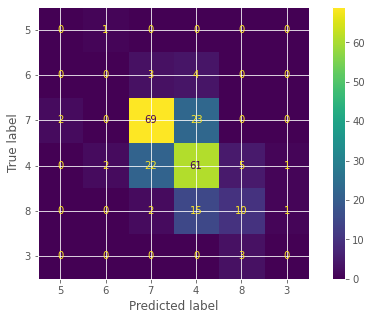

mean accuracy
0.625
weigted precision
0.6116574082100479
weighted recall
0.625
weighted f1 score
0.6146178632933745
Random Forest


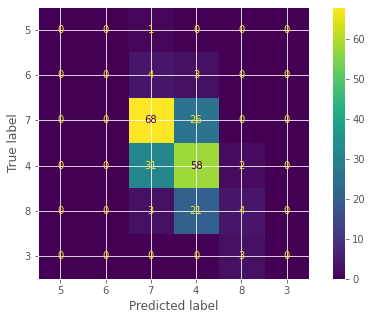

mean accuracy
0.5803571428571429
weigted precision
0.5404157704099293
weighted recall
0.5803571428571429
weighted f1 score
0.5477735278324043
GaussianNB


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


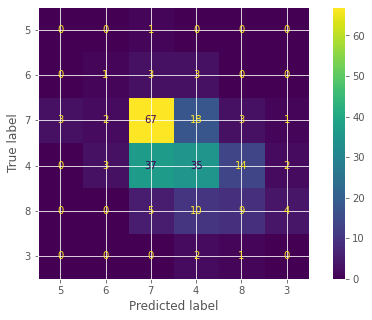

mean accuracy
0.5
weigted precision
0.5047890561091694
weighted recall
0.5
weighted f1 score
0.49622184851881324


In [156]:
from sklearn.utils import multiclass
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

for model, name in zip(models, names):
  print(name)
  model_pred = model.predict(X_test)
  labels = df['quality'].unique()
  fig, ax = plt.subplots(figsize=(8, 5))
  cmp = ConfusionMatrixDisplay(
  confusion_matrix(y_test, model_pred),
  display_labels=labels,
  )
  cmp.plot(ax=ax)
  plt.show()
  print("mean accuracy")
  print(model.score(X_test, y_test))
  print("weigted precision")
  print(precision_score(y_test, model_pred, labels=labels, average='weighted'))
  print("weighted recall")
  print(recall_score(y_test, model_pred, labels=labels, average='weighted'))
  print("weighted f1 score")
  print(f1_score(y_test, model_pred, labels=labels, average='weighted'))

# 5) Применить autoML к моделям

In [157]:
from sklearn.model_selection import GridSearchCV

In [158]:
estimators_list = list(range(15,25))
max_depth_list = list(range(2,6))
var_smoothing_list = np.linspace(1e-10,1e-8, 20).tolist()
GradientBoostingParameters = dict(n_estimators=estimators_list, max_depth=max_depth_list)
RandomForestParameters = dict(n_estimators=estimators_list, max_depth=max_depth_list)
GaussianNBParameters = dict(var_smoothing=var_smoothing_list)
params_list = [GradientBoostingParameters, RandomForestParameters, GaussianNBParameters]

In [159]:

results = []
for model, name, params in zip(models, names, params_list):
  print(name)
  grid = GridSearchCV(model, params, scoring='f1_weighted', return_train_score=False, verbose=3)
  tqdm(grid.fit(X_train, y_train))
  model = grid.best_estimator_
  print(grid.best_score_)
  print(grid.best_params_)
  print(grid.best_estimator_)
  results.append([grid.best_score_,grid.best_params_,grid.best_estimator_])
  pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

Gradient Boosting
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ......max_depth=2, n_estimators=15;, score=0.563 total time=   0.2s
[CV 2/5] END ......max_depth=2, n_estimators=15;, score=0.578 total time=   0.1s
[CV 3/5] END ......max_depth=2, n_estimators=15;, score=0.626 total time=   0.2s
[CV 4/5] END ......max_depth=2, n_estimators=15;, score=0.568 total time=   0.2s
[CV 5/5] END ......max_depth=2, n_estimators=15;, score=0.562 total time=   0.2s
[CV 1/5] END ......max_depth=2, n_estimators=16;, score=0.576 total time=   0.2s
[CV 2/5] END ......max_depth=2, n_estimators=16;, score=0.577 total time=   0.2s
[CV 3/5] END ......max_depth=2, n_estimators=16;, score=0.647 total time=   0.2s
[CV 4/5] END ......max_depth=2, n_estimators=16;, score=0.557 total time=   0.3s
[CV 5/5] END ......max_depth=2, n_estimators=16;, score=0.555 total time=   0.3s
[CV 1/5] END ......max_depth=2, n_estimators=17;, score=0.577 total time=   0.3s
[CV 2/5] END ......max_depth=

0it [00:00, ?it/s]


0.6310685739966131
{'max_depth': 5, 'n_estimators': 24}
GradientBoostingClassifier(max_depth=5, n_estimators=24, random_state=42)
Random Forest
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ......max_depth=2, n_estimators=15;, score=0.516 total time=   0.0s
[CV 2/5] END ......max_depth=2, n_estimators=15;, score=0.513 total time=   0.0s
[CV 3/5] END ......max_depth=2, n_estimators=15;, score=0.513 total time=   0.0s
[CV 4/5] END ......max_depth=2, n_estimators=15;, score=0.521 total time=   0.0s
[CV 5/5] END ......max_depth=2, n_estimators=15;, score=0.512 total time=   0.0s
[CV 1/5] END ......max_depth=2, n_estimators=16;, score=0.505 total time=   0.0s
[CV 2/5] END ......max_depth=2, n_estimators=16;, score=0.519 total time=   0.0s
[CV 3/5] END ......max_depth=2, n_estimators=16;, score=0.513 total time=   0.0s
[CV 4/5] END ......max_depth=2, n_estimators=16;, score=0.526 total time=   0.0s
[CV 5/5] END ......max_depth=2, n_estimators=16;, score=0.496 tot

0it [00:00, ?it/s]

0.6129058017164783
{'max_depth': 5, 'n_estimators': 17}
RandomForestClassifier(max_depth=5, n_estimators=17, random_state=42)
GaussianNB
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END ...............var_smoothing=1e-10;, score=0.617 total time=   0.0s
[CV 2/5] END ...............var_smoothing=1e-10;, score=0.552 total time=   0.0s
[CV 3/5] END ...............var_smoothing=1e-10;, score=0.551 total time=   0.0s


[CV 4/5] END ...............var_smoothing=1e-10;, score=0.574 total time=   0.0s
[CV 5/5] END ...............var_smoothing=1e-10;, score=0.546 total time=   0.0s
[CV 1/5] END var_smoothing=6.210526315789473e-10;, score=0.611 total time=   0.0s
[CV 2/5] END var_smoothing=6.210526315789473e-10;, score=0.577 total time=   0.0s
[CV 3/5] END var_smoothing=6.210526315789473e-10;, score=0.547 total time=   0.0s
[CV 4/5] END var_smoothing=6.210526315789473e-10;, score=0.567 total time=   0.0s
[CV 5/5] END var_smoothing=6.210526315789473e-10;, score=0.556 total time=   0.0s
[CV 1/5] END var_smoothing=1.1421052631578948e-09;, score=0.611 total time=   0.0s
[CV 2/5] END var_smoothing=1.1421052631578948e-09;, score=0.576 total time=   0.0s
[CV 3/5] END var_smoothing=1.1421052631578948e-09;, score=0.534 total time=   0.0s
[CV 4/5] END var_smoothing=1.1421052631578948e-09;, score=0.561 total time=   0.0s
[CV 5/5] END var_smoothing=1.1421052631578948e-09;, score=0.556 total time=   0.0s
[CV 1/5] END 

0it [00:00, ?it/s]

0.57230367891519
{'var_smoothing': 9.478947368421051e-09}
GaussianNB(var_smoothing=9.478947368421051e-09)


# 6) посмотреть результаты затюненых моделей

In [160]:
for name, res in zip(names, results):
  print(name)
  print('grid.best_score_')
  print(res[0])
  print('grid.best_params_')
  print(res[1])
  print('grid.best_estimator_')
  print(res[2])
  print('\n\n')

Gradient Boosting
grid.best_score_
0.6310685739966131
grid.best_params_
{'max_depth': 5, 'n_estimators': 24}
grid.best_estimator_
GradientBoostingClassifier(max_depth=5, n_estimators=24, random_state=42)



Random Forest
grid.best_score_
0.6129058017164783
grid.best_params_
{'max_depth': 5, 'n_estimators': 17}
grid.best_estimator_
RandomForestClassifier(max_depth=5, n_estimators=17, random_state=42)



GaussianNB
grid.best_score_
0.57230367891519
grid.best_params_
{'var_smoothing': 9.478947368421051e-09}
grid.best_estimator_
GaussianNB(var_smoothing=9.478947368421051e-09)





In [161]:
# models = [GradientBoostingClassifier(max_depth=5, n_estimators=24, random_state=42),
#           RandomForestClassifier(max_depth=5, n_estimators=17, random_state=42),
#           GaussianNB(var_smoothing=9.478947368421051e-09),
#           ]


In [162]:
# for model, name in zip(models, names):
#   model.fit(X_train, y_train)

Gradient Boosting


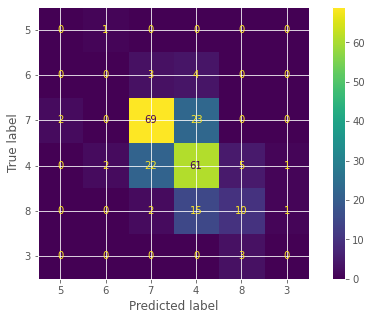

mean accuracy
0.625
weigted precision
0.6116574082100479
weighted recall
0.625
weighted f1 score
0.6146178632933745
Random Forest


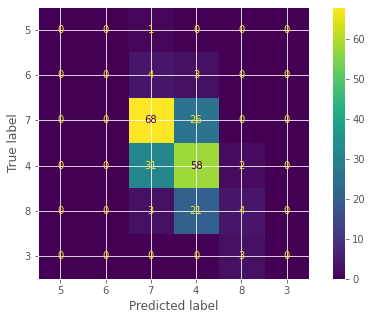

mean accuracy
0.5803571428571429
weigted precision
0.5404157704099293
weighted recall
0.5803571428571429
weighted f1 score
0.5477735278324043
GaussianNB


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


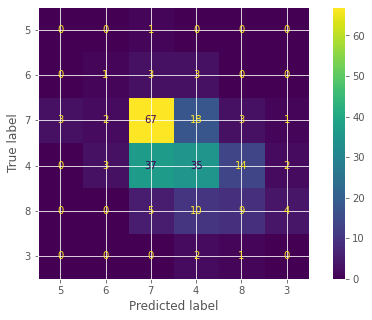

mean accuracy
0.5
weigted precision
0.5047890561091694
weighted recall
0.5
weighted f1 score
0.49622184851881324


In [163]:
for model, name in zip(models, names):
  print(name)
  model_pred = model.predict(X_test)
  labels = df['quality'].unique()
  fig, ax = plt.subplots(figsize=(8, 5))
  cmp = ConfusionMatrixDisplay(
  confusion_matrix(y_test, model_pred),
  display_labels=labels,
  )
  cmp.plot(ax=ax)
  plt.show()
  print("mean accuracy")
  print(model.score(X_test, y_test))
  print("weigted precision")
  print(precision_score(y_test, model_pred, labels=labels, average='weighted'))
  print("weighted recall")
  print(recall_score(y_test, model_pred, labels=labels, average='weighted'))
  print("weighted f1 score")
  print(f1_score(y_test, model_pred, labels=labels, average='weighted'))


In [164]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [165]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

classifier=GradientBoostingClassifier(n_estimators=n_tree, max_depth=depth, random_state=42)
classifier.fit(X_train,y_train)
y_pred=classifier.predict(X_test)
print(f"Model Accuracy : {accuracy_score(y_pred,y_test)*100:.2f}%")
print(f"Model F1-Score : {f1_score(y_pred,y_test,average='weighted')*100:.2f}%")
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 5)
print("Cross Val Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Cross Val Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print(classification_report(y_pred,y_test,zero_division=1))

Model Accuracy : 62.50%
Model F1-Score : 63.58%
Cross Val Accuracy: 64.69 %
Cross Val Standard Deviation: 3.47 %
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         3
           5       0.73      0.71      0.72        97
           6       0.67      0.59      0.63       103
           7       0.36      0.59      0.44        17
           8       0.00      0.00      0.00         2

    accuracy                           0.62       224
   macro avg       0.29      0.32      0.30       224
weighted avg       0.65      0.62      0.64       224



# 7) Добавление синтетических данных

In [166]:
from imblearn.over_sampling import SMOTE

In [167]:
sm=SMOTE(sampling_strategy='not majority',  random_state=42)

In [168]:
X_balanced,y_balanced =sm.fit_resample(X,y)

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, train_size=0.8, stratify=y_balanced, random_state=42, shuffle=True)

In [170]:
models = [GradientBoostingClassifier(n_estimators=n_tree, max_depth=depth, random_state=42),
          RandomForestClassifier(n_estimators=n_tree, max_depth=depth, random_state=42),
          GaussianNB(),
          ]

#fit_models = [clf.fit(X_train, y_train) for clf in models]

names = ['Gradient Boosting', 
         'Random Forest',
         'GaussianNB',
         ]

In [171]:
for model, name in zip(models, names):
  model.fit(X_train, y_train)

Gradient Boosting


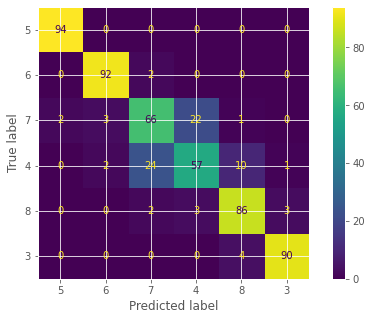

mean accuracy
0.8599290780141844
weigted precision
0.8556336404555932
weighted recall
0.8599290780141844
weighted f1 score
0.8570295820690836
Random Forest


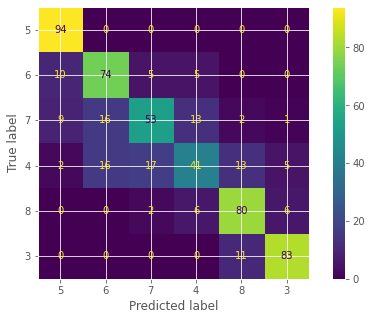

mean accuracy
0.7535460992907801
weigted precision
0.7438311037723844
weighted recall
0.7535460992907801
weighted f1 score
0.7422391201305469
GaussianNB


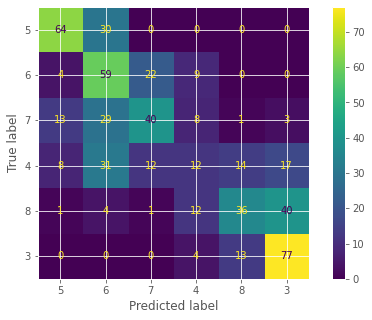

mean accuracy
0.5106382978723404
weigted precision
0.5035459702940381
weighted recall
0.5106382978723404
weighted f1 score
0.49029708136705147


In [172]:
from sklearn.utils import multiclass
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

for model, name in zip(models, names):
  print(name)
  model_pred = model.predict(X_test)
  labels = df['quality'].unique()
  fig, ax = plt.subplots(figsize=(8, 5))
  cmp = ConfusionMatrixDisplay(
  confusion_matrix(y_test, model_pred),
  display_labels=labels,
  )
  cmp.plot(ax=ax)
  plt.show()
  print("mean accuracy")
  print(model.score(X_test, y_test))
  print("weigted precision")
  print(precision_score(y_test, model_pred, labels=labels, average='weighted'))
  print("weighted recall")
  print(recall_score(y_test, model_pred, labels=labels, average='weighted'))
  print("weighted f1 score")
  print(f1_score(y_test, model_pred, labels=labels, average='weighted'))

# 8) autoML после добавления синтетических данных

In [173]:

results = []
for model, name, params in zip(models, names, params_list):
  print(name)
  grid = GridSearchCV(model, params, scoring='f1_weighted', return_train_score=False, verbose=3)
  grid.fit(X_train, y_train)
  model = grid.best_estimator_
  print(grid.best_score_)
  print(grid.best_params_)
  print(grid.best_estimator_)
  results.append([grid.best_score_,grid.best_params_,grid.best_estimator_])
  pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

Gradient Boosting
Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END ......max_depth=2, n_estimators=15;, score=0.579 total time=   0.4s
[CV 2/5] END ......max_depth=2, n_estimators=15;, score=0.644 total time=   0.5s
[CV 3/5] END ......max_depth=2, n_estimators=15;, score=0.565 total time=   0.4s
[CV 4/5] END ......max_depth=2, n_estimators=15;, score=0.599 total time=   0.4s
[CV 5/5] END ......max_depth=2, n_estimators=15;, score=0.630 total time=   0.4s
[CV 1/5] END ......max_depth=2, n_estimators=16;, score=0.577 total time=   0.5s
[CV 2/5] END ......max_depth=2, n_estimators=16;, score=0.637 total time=   0.5s
[CV 3/5] END ......max_depth=2, n_estimators=16;, score=0.572 total time=   0.5s
[CV 4/5] END ......max_depth=2, n_estimators=16;, score=0.615 total time=   0.5s
[CV 5/5] END ......max_depth=2, n_estimators=16;, score=0.651 total time=   0.5s
[CV 1/5] END ......max_depth=2, n_estimators=17;, score=0.599 total time=   0.5s
[CV 2/5] END ......max_depth=

# 9) Обзор результатов

In [174]:
for name, res in zip(names, results):
  print(name)
  print('grid.best_score_')
  print(res[0])
  print('grid.best_params_')
  print(res[1])
  print('grid.best_estimator_')
  print(res[2])
  print('\n\n')

Gradient Boosting
grid.best_score_
0.7873754774603255
grid.best_params_
{'max_depth': 5, 'n_estimators': 24}
grid.best_estimator_
GradientBoostingClassifier(max_depth=5, n_estimators=24, random_state=42)



Random Forest
grid.best_score_
0.6759195438230212
grid.best_params_
{'max_depth': 5, 'n_estimators': 23}
grid.best_estimator_
RandomForestClassifier(max_depth=5, n_estimators=23, random_state=42)



GaussianNB
grid.best_score_
0.49312585636624356
grid.best_params_
{'var_smoothing': 1.1421052631578948e-09}
grid.best_estimator_
GaussianNB(var_smoothing=1.1421052631578948e-09)





Gradient Boosting


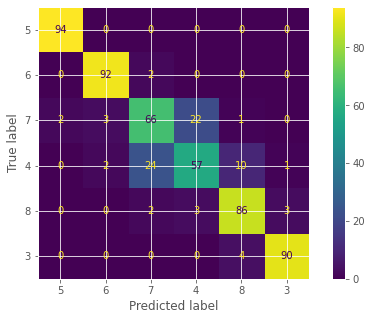

mean accuracy
0.8599290780141844
weigted precision
0.8556336404555932
weighted recall
0.8599290780141844
weighted f1 score
0.8570295820690836
Random Forest


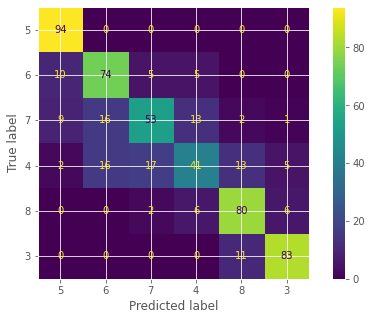

mean accuracy
0.7535460992907801
weigted precision
0.7438311037723844
weighted recall
0.7535460992907801
weighted f1 score
0.7422391201305469
GaussianNB


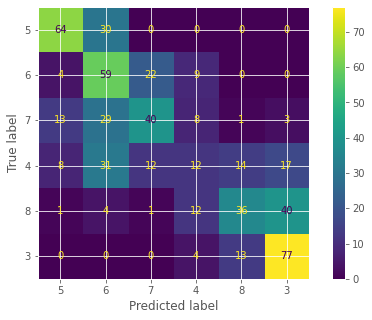

mean accuracy
0.5106382978723404
weigted precision
0.5035459702940381
weighted recall
0.5106382978723404
weighted f1 score
0.49029708136705147


In [175]:
for model, name in zip(models, names):
  print(name)
  model_pred = model.predict(X_test)
  labels = df['quality'].unique()
  fig, ax = plt.subplots(figsize=(8, 5))
  cmp = ConfusionMatrixDisplay(
  confusion_matrix(y_test, model_pred),
  display_labels=labels,
  )
  cmp.plot(ax=ax)
  plt.show()
  print("mean accuracy")
  print(model.score(X_test, y_test))
  print("weigted precision")
  print(precision_score(y_test, model_pred, labels=labels, average='weighted'))
  print("weighted recall")
  print(recall_score(y_test, model_pred, labels=labels, average='weighted'))
  print("weighted f1 score")
  print(f1_score(y_test, model_pred, labels=labels, average='weighted'))
